# Dynamical Magnetic Xray Scattering

This notebook includes examples of the basic usage of dynamical magnetic X-ray scattering.

## Setup

In [1]:
import udkm1Dsim as ud
u = ud.u #  import the pint unit registry from udkm1Dsim
import scipy.constants as constants
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
u.setup_matplotlib() #  use matplotlib with pint units

## Atom creation

Initialize all required atoms using the `Atom` class.

In [2]:
Fe = ud.Atom('Fe')
Cr = ud.Atom('Cr')
Si = ud.Atom('Si')

## Unit cell creation

Create all required unit cells using the `UnitCell` class and add `Atom` objects to them.

In [3]:
# c-axis
c_Fe = 2.86*u.angstrom
c_Cr = 2.91*u.angstrom
c_Si = 5*u.angstrom

# we only care about basic properties for now
propFe = {}
propFe['a_axis'] = c_Fe # aAxis
propFe['b_axis'] = c_Fe # bAxis

Fe_uc = ud.UnitCell('Fe', 'Fe', c_Fe, **propFe)
Fe_uc.add_atom(Fe, 0)
Fe_uc.add_atom(Fe, 0.5)

propCr = {}
propCr['a_axis'] = c_Cr # aAxis
propCr['b_axis'] = c_Cr # bAxis

Cr_uc = ud.UnitCell('Cr', 'Cr', c_Cr, **propCr)
Cr_uc.add_atom(Cr, 0)
Cr_uc.add_atom(Cr, 0.5)

propSi = {}
propSi['a_axis'] = c_Si # aAxis
propSi['b_axis'] = c_Si # bAxis

Si_uc = ud.UnitCell('Si', 'Si', c_Si, **propSi)
Si_uc.add_atom(Si, 0)

## Structure creation

Create an actual sample using the `Structure` class and add `UnitCell` objects to it.

In [4]:
N_Fe = 5
N_Cr = 4

S = ud.Structure('Super Lattice')

DL = ud.Structure('Double Layer Fe+Cr')
DL.add_sub_structure(Fe_uc, N_Fe)
DL.add_sub_structure(Cr_uc, N_Cr)

S.add_sub_structure(DL, 20)

# add Si substrate
substrate = ud.Structure('Si substrate')
substrate.add_sub_structure(Si_uc, 1000)
S.add_substrate(substrate)

distances, _, _ = S.get_distances_of_layers() # distance vector of all layers

## Strain map creation

Since the `Heat` and `Phonon` simulations are not implemented, yet, the `strain_map` is created by a simple script, which mimics a strain wave traveling into the sample.

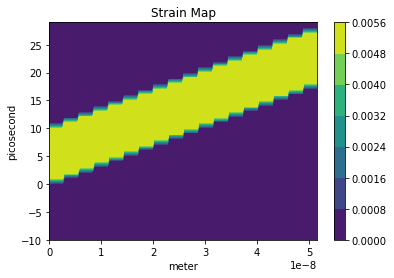

In [5]:
delays = np.r_[-10:30:1]*u.ps #  define the delays of the simulations
strain_map = np.zeros([len(delays), S.get_number_of_layers()]) #  allocate size of the strain_map

for i, delay in enumerate(delays):
    factor = 10
    width = 100
    if delay > 0:
        end = int(delay.magnitude * factor)
        start = end - width
        if start < 0: start = 0
        if end < 0: end = 0
        strain_map[i, start:end] = 0.005

# strain_vectors are a subset of the strain_map and are required to speed up the xray simulations
strain_vectors =  [np.array(np.linspace(np.min(strain_map), np.max(strain_map), 100))]*S.get_number_of_unique_layers()

# plot the artifical strain_map
plt.figure()
plt.contourf(distances, delays, strain_map)
plt.title('Strain Map')
plt.colorbar()
plt.show()

## Initialize dynamical magnetic Xray simulation

Create a dynamical Xray simulation using the `XrayDynMag` class and add a `Structure` object as sample.
Also set the photon energy and $q_z$ range for the actual simulations.

In [6]:
force_recalc = True #  always recalculate results and do not consider cached results
mag = ud.XrayDynMag(S, force_recalc)
mag.disp_messages = True #  enable displaying messages from within the simulations
mag.save_data = False #  do not save results for caching

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized


## Homogeneous Xray simulation

For the case of homogeneously strained samples, the dynamical Xray scattering simulations can be greatly simplyfied, which saves a lot of computational time.

### $q_z$-scan

Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.634434 s


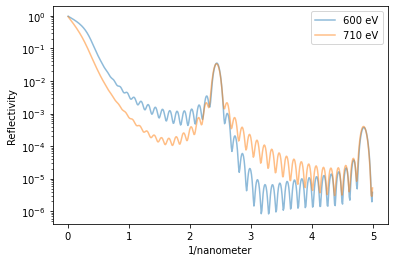

In [7]:
mag.energy = np.r_[600, 710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range

R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation

plt.figure()
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}'.format(mag.energy[0]), alpha=0.5)
plt.semilogy(mag.qz[1, :], R_hom[1, :], label='{}'.format(mag.energy[1]), alpha=0.5)
plt.ylabel('Reflectivity')
plt.legend()
plt.show()

### Post-Processing

Simple convolution of the results with an arbitrary function handle.

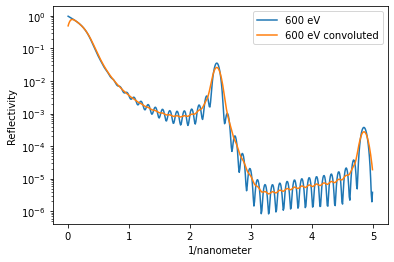

In [8]:
FWHM = 0.01/1e-10 # Angstrom
sigma = FWHM /2.3548
        
handle = lambda x: np.exp(-((x)/sigma)**2/2)
y_conv = mag.conv_with_function(R_hom[0,:], mag._qz[0,:], handle)

plt.figure()
plt.semilogy(mag.qz[0,:], R_hom[0,:], label='{}'.format(mag.energy[0]))
plt.semilogy(mag.qz[0,:], y_conv, label='{} convoluted'.format(mag.energy[0]))
plt.ylabel('Reflectivity')
plt.legend()
plt.show()

### Energy-scan

Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 3.175762 s


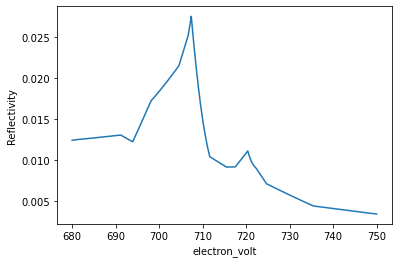

In [9]:
mag.energy = np.r_[680:750:0.01]*u.eV #  set the energy range
mag.qz = np.r_[2.5]/u.nm # qz range

R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation

plt.figure()
plt.plot(mag.energy, R_hom[:, 0])
plt.ylabel('Reflectivity')
plt.show()

## Sequential dynamical Xray simulation

Do a time-resolved magnetic xray scatting simulation for the above defined `strain_map` without parallelization.

In [10]:
mag.energy = np.r_[600, 710]*u.eV #  set two photon energies
mag.qz = np.r_[0.1:5:0.1]/u.nm #  qz range

magnetization_map = np.zeros([len(delays), S.get_number_of_layers(), 3])

R_seq, R_seq_phi = mag.inhomogeneous_reflectivity(strain_map, magnetization_map)

Calculating _inhomogeneous_reflectivity_ ...



Elapsed time for _inhomogeneous_reflectivity_: 35.175697 s


### Sequential Results

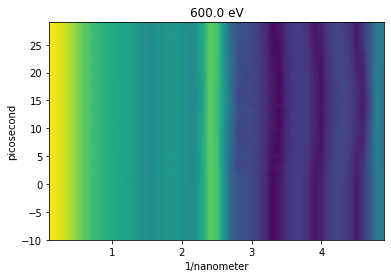

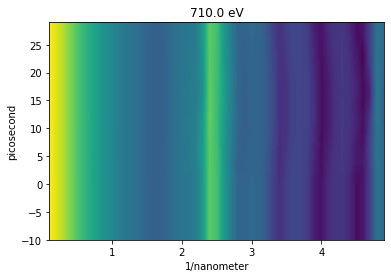

In [11]:
for i, energy in enumerate(mag.energy):
    plt.figure()
    plt.contourf(mag.qz[i,:], delays, np.log10(R_seq[:, i, :]), levels=100)
    plt.title('{:0.1f} eV'.format(energy.magnitude))
    plt.show()

## Parallel dynamical Xray scattering

Parallelization needs still to be implemented, but will work similarly as with XrayDyn.

You need to install the `udkm1Dsim` with the `parallel` option which essentially add the Dask package to the requirements:

```
> pip install udkm1Dsim[parallel]
```

You can also install/add Dask manually, e.g. via pip:

```
> pip install dask
```

Please refer to the [Dask documentation](https://docs.dask.org/en/latest/) for more details on parallel computing in Python.


In [ ]:
try:
    from dask.distributed import Client
    client = Client()

    R_seq, R_seq_phi = mag.inhomogeneous_reflectivity(strain_map, magnetization_map, calc_type='parallel', dask_client=client)

    for i, energy in enumerate(mag.energy):
        plt.figure()
        plt.contourf(mag.qz[i,:], delays, np.log10(R_seq[:, i, :]), levels=100)
        plt.title('{:0.1f} eV'.format(energy.magnitude))
        plt.show()
except:
    pass

Calculating _inhomogeneous_reflectivity_ ...


## Polarization Dependence

### Non-Magnetic sample

The current sample is currently not magnetic, therefore, there should no scattering from sigma to pi and vice versa.

In [ ]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(3, 3)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> sigma'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(3, 4)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> pi'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('non-magnetic sample: sigma')
plt.legend()
plt.show()

In [ ]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(4, 4)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> pi'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(4, 3)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> sigma'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('non-magnetic sample: pi')
plt.legend()
plt.show()

### Magnetic Sample

Now compare the scattering with a ferromagnetic and antiferromagnetic sample structure.

In [ ]:
# Fe atom with magnetization in-plane to the left
Fe_left = ud.Atom('Fe', mag_amplitude=1, mag_phi=90*u.deg, mag_gamma=90*u.deg, id='Fe left')
# Fe atom with magnetization in-plane to the right
Fe_right = ud.Atom('Fe', mag_amplitude=1, mag_phi=90*u.deg, mag_gamma=270*u.deg, id='Fe right')

# Fe unit cell with left in-plane magnetization
Fe_uc_left = ud.UnitCell('Fe_left', 'Fe', c_Fe, **propFe)
Fe_uc_left.add_atom(Fe_left, 0)
Fe_uc_left.add_atom(Fe_left, 0.5)

# Fe unit cell with right in-plane magnetization
Fe_uc_right = ud.UnitCell('Fe_right', 'Fe', c_Fe, **propFe)
Fe_uc_right.add_atom(Fe_right, 0)
Fe_uc_right.add_atom(Fe_right, 0.5)

#### FM Sample

In [ ]:
N_Fe = 5
N_Cr = 4

SFM = ud.Structure('FM Super Lattice')

DLFM = ud.Structure('FM Double Layer Fe+Cr')
DLFM.add_sub_structure(Fe_uc_left, N_Fe)
DLFM.add_sub_structure(Cr_uc, N_Cr)

SFM.add_sub_structure(DLFM, 20)

# add Si substrate
SFM.add_substrate(substrate)

distances, _, _ = SFM.get_distances_of_layers() # distance vector of all unit cells

mag.S = SFM # replace the sample in the current simulation

In [ ]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(3, 3)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> sigma'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(3, 4)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> pi'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('FM sample: sigma')
plt.legend()
plt.show()

In [ ]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(4, 4)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> pi'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(4, 3)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> sigma'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('FM sample: pi')
plt.legend()
plt.show()

In [ ]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(1, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: circ +'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(2, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: circ -'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('FM sample: circular')
plt.legend()
plt.show()

Same again with the non-magnetic sample

In [ ]:
mag.S = S # change again to the inital sample

mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(1, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: circ +'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(2, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: circ -'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('FM sample: circular')
plt.legend()
plt.show()

#### AFM Sample

In [ ]:
N_Fe = 5
N_Cr = 4

SAFM = ud.Structure('AFM Super Lattice')

DLAFM = ud.Structure('AFM Double Layer Fe+Cr')
DLAFM.add_sub_structure(Fe_uc_left, N_Fe)
DLAFM.add_sub_structure(Cr_uc, N_Cr)
DLAFM.add_sub_structure(Fe_uc_right, N_Fe)
DLAFM.add_sub_structure(Cr_uc, N_Cr)

SAFM.add_sub_structure(DLAFM, 10)

# add Si substrate
SAFM.add_substrate(substrate)

distances, _, _ = SAFM.get_distances_of_layers() # distance vector of all unit cells

mag.S = SAFM # replace the sample in the current simulation

In [ ]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()

mag.set_polarization(3, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> unpolarized'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(3, 3)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> sigma'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(3, 4)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> pi'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('AFM sample: sigma')
plt.legend()
plt.show()

In [ ]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()

mag.set_polarization(4, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> unpolarized'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(4, 4)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> pi'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(4, 3)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> sigma'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('AFM sample: pi')
plt.legend()
plt.show()

In [ ]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(1, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: circ +'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(2, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: circ -'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('AFM sample: circular')
plt.legend()
plt.show()

#### Engery vs qz

In [ ]:
mag.energy = np.r_[680:750]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range
mag.set_polarization(3, 0)

R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation

plt.figure()

plt.figure(figsize=[12,12])
plt.contourf(mag.qz[0,:], mag.energy, np.log10(R_hom[:, :]), levels=100)
plt.colorbar()

plt.ylabel('Reflectivity')
plt.title('AFM sample: circular')
plt.show()

### Amorphous Magnetic Sample

Check that we get the same results in magnetic scattering as from a crystalline sample.

In [ ]:
N_Fe = 5
N_Cr = 4

amAFM = ud.Structure('amorphous AFM Super Lattice')
amDLAFM = ud.Structure('amourphous AFM Double Layer Fe+Cr')

amFeLeftLay = ud.AmorphousLayer('Fe_left_amorphous', "Fe left amorphous", Fe_uc.c_axis*N_Fe, Fe_uc.density, atom=Fe_left)
amFeRightLay = ud.AmorphousLayer('Fe_right_amorphous', "Fe right amorphous", Fe_uc.c_axis*N_Fe, Fe_uc.density, atom=Fe_right)

amCrLay = ud.AmorphousLayer('Cr_amorphous', "Cr amorphous", Cr_uc.c_axis * N_Cr, Cr_uc.density, atom=Cr)


amDLAFM.add_sub_structure(amFeLeftLay)
amDLAFM.add_sub_structure(amCrLay)
amDLAFM.add_sub_structure(amFeRightLay)
amDLAFM.add_sub_structure(amCrLay)

amAFM.add_sub_structure(amDLAFM, 10)

In [ ]:
# add Si substrate
amAFM.add_substrate(substrate)

distances, _, _ = amAFM.get_distances_of_layers() # distance vector of all unit cells

mag.S = amAFM # replace the sample in the current simulation

In [ ]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()

mag.set_polarization(3, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> unpolarized'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(3, 3)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> sigma'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(3, 4)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> pi'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('AFM sample: sigma')
plt.legend()
plt.show()